# Setup

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
procs_added = pd.read_csv("procs_added.txt", index_col=None, names=["tick", "machineID", "procType", "sla", "actualComp", "migrated"])
procs_current = pd.read_csv("procs_current.txt", index_col=None, names=["tick", "machineID", "isActive", "sla", "actualComp", "compDone"])
procs_done = pd.read_csv("procs_done.txt", index_col=None, names=["tick", "machineID", "procType", "sla", "ticksPassed", "actualComp"])
procs_killed = pd.read_csv("procs_killed.txt", index_col=None, names=["tick", "machineID", "sla", "compDone", "memUsed"])

util_metrics = pd.read_csv("usage.txt", index_col=None, names=["tick", "machineID", "maxTicksPassedToSlaRatio", "memUsage", "qlen", "ticksInQ", "ticksLeftOver"])

# sched_decisions = pd.read_csv("sched.txt", index_col=None, names=["tick", "machineID", "sla", "compDone", "ticksPassed", "ticksGiven", "done"])


# prepare
procs_current["compLeft"] = procs_current["sla"] - procs_current["compDone"]
procs_added["compLeft"] = procs_added["sla"]
all_procs = pd.concat([procs_current[['tick', "compLeft"]], procs_added[["tick", "compLeft"]]])
load_num_procs_per_tick = procs_added[["tick"]].groupby("tick").size().reset_index(name='numProcsCurrent')
load_work_per_tick = procs_added.groupby("tick").sum().reset_index()

procs_done['timePassedAsPct'] = (100 * procs_done["ticksPassed"]) / procs_done["sla"]

procs_late = procs_done.where(procs_done["ticksPassed"] > procs_done["sla"]).dropna().reset_index(drop=True)
procs_late = procs_late.where(procs_late["ticksPassed"] > procs_late["actualComp"]).dropna().reset_index(drop=True)


In [3]:
util_metrics.where(util_metrics["ticksLeftOver"]>0).dropna()

,tick,machineID,maxTicksPassedToSlaRatio,memUsage,qlen,ticksInQ,ticksLeftOver
1,1.0,0.0,0.00,0.01,3.0,3.149138,0.923110
3,2.0,1.0,0.26,0.01,2.0,3.916853,3.699667
4,3.0,0.0,0.25,0.04,5.0,9.307973,0.646605
5,3.0,1.0,0.00,0.00,2.0,0.417277,3.589011
6,4.0,0.0,0.00,0.01,3.0,2.651747,1.371549
...,...,...,...,...,...,...,...
1994,998.0,0.0,0.68,0.03,3.0,10.680497,0.699197
1995,998.0,1.0,0.61,0.04,4.0,12.797798,2.808135
1996,999.0,0.0,0.37,0.01,4.0,3.257350,0.756231
1997,999.0,1.0,0.24,0.01,3.0,4.500402,0.344293


# Overall Overview

<Figure size 1500x600 with 0 Axes>

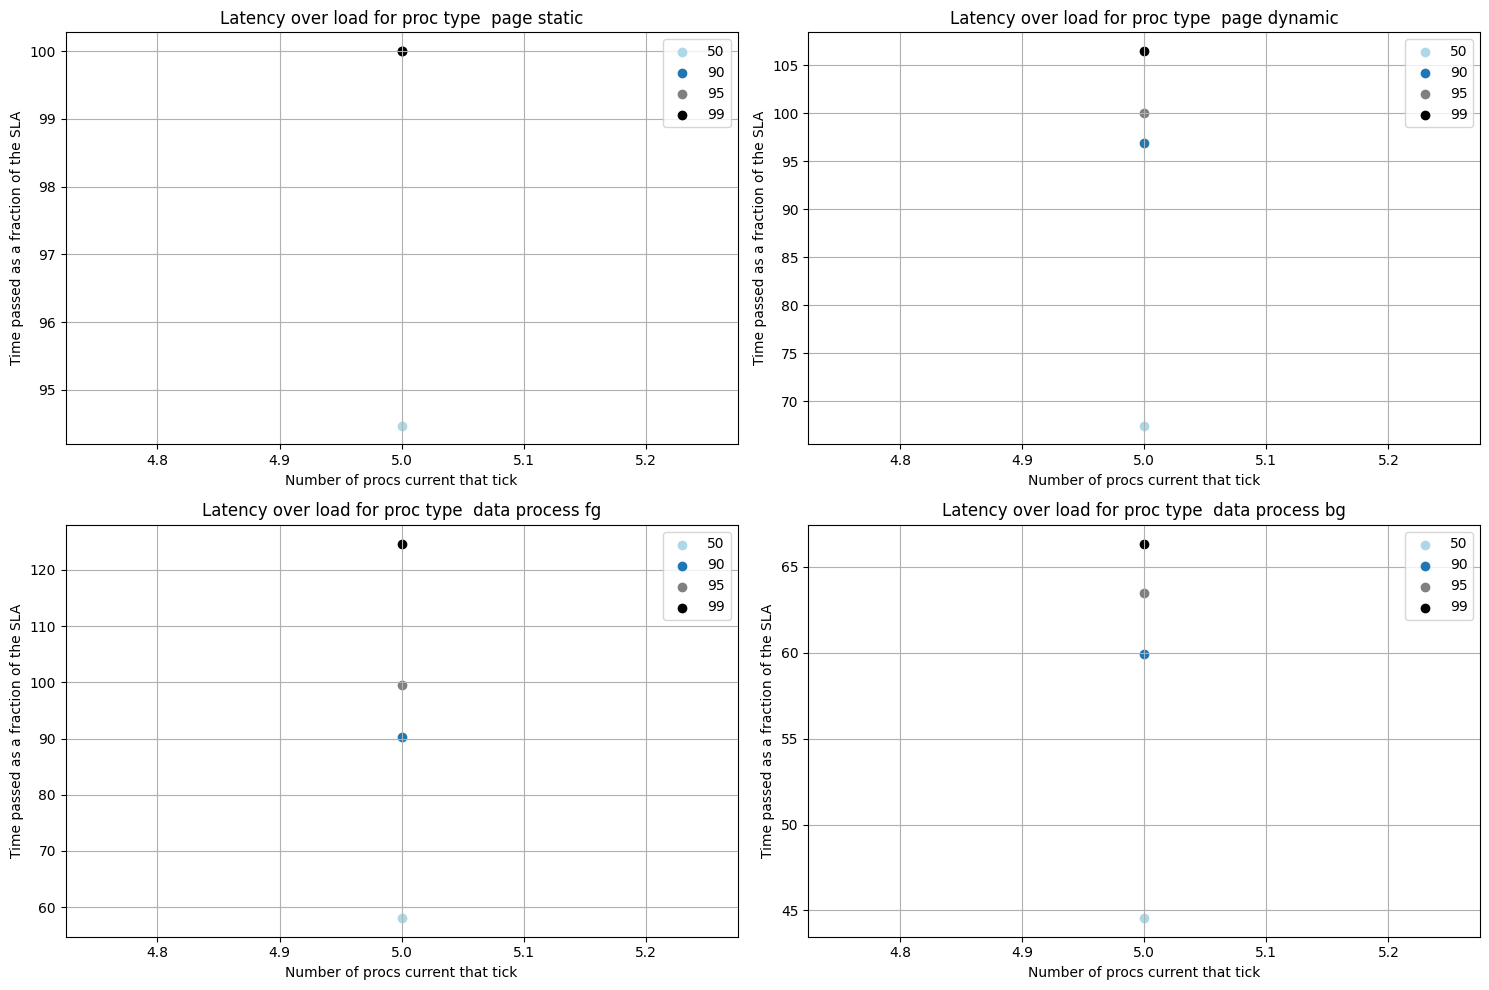

In [4]:
# Proc latency (as a percentage of their SLA) over the load (number of procs currently live)

proc_timings = pd.merge(procs_done, load_num_procs_per_tick, on='tick', how='left')

def get_percentile(pctile, proc_type):
    return proc_timings.where(proc_timings["procType"] == proc_type)[["numProcsCurrent", "timePassedAsPct"]].groupby("numProcsCurrent").quantile(pctile / 100).reset_index()

plt.figure(figsize=(15,6))

unique_ids = proc_timings['procType'].unique()

# Set up subplots
num_plots = len(unique_ids)
num_cols = 2  # Adjust as needed
num_rows = -(-num_plots // num_cols)  # Ceiling division

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_rows))
if num_rows > 1 and num_cols > 1:
    axes = axes.flatten()

# Plot each machine's data
for i, id_ in enumerate(unique_ids):
    ax = axes[i]
    ax.scatter(get_percentile(50, id_)["numProcsCurrent"], get_percentile(50, id_)["timePassedAsPct"], color='lightblue', label="50")
    ax.plot(get_percentile(50, id_)["numProcsCurrent"], get_percentile(50, id_)["timePassedAsPct"], color='lightblue')

    ax.scatter(get_percentile(90, id_)["numProcsCurrent"], get_percentile(90, id_)["timePassedAsPct"], label="90")
    ax.plot(get_percentile(90, id_)["numProcsCurrent"], get_percentile(90, id_)["timePassedAsPct"])

    ax.scatter(get_percentile(95, id_)["numProcsCurrent"], get_percentile(95, id_)["timePassedAsPct"], color='grey', label="95")
    ax.plot(get_percentile(95, id_)["numProcsCurrent"], get_percentile(95, id_)["timePassedAsPct"], color='grey')

    ax.scatter(get_percentile(95, id_)["numProcsCurrent"], get_percentile(99, id_)["timePassedAsPct"], color='black', label="99")
    ax.plot(get_percentile(95, id_)["numProcsCurrent"], get_percentile(99, id_)["timePassedAsPct"], color='black')

    ax.set_title(f'Latency over load for proc type {id_}')
    ax.set_xlabel('Number of procs current that tick')
    ax.set_ylabel('Time passed as a fraction of the SLA')
    ax.legend()
    ax.grid(True)

# If there are unused subplots, hide them
for i in range(len(unique_ids), num_rows * num_cols):
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [5]:
late = proc_timings.where((proc_timings["timePassedAsPct"] > 100.1)).dropna()
typed = late.where(late["procType"].str.contains("dynamic")).dropna()

typed.sort_values("timePassedAsPct", ascending=False).reset_index(drop=True)

,tick,machineID,procType,sla,ticksPassed,actualComp,timePassedAsPct,numProcsCurrent
0,650.0,0.0,page dynamic,3.866300,5.730501,3.866300,148.216660,5.0
1,419.0,0.0,page dynamic,2.241486,3.169249,2.241486,141.390531,5.0
2,560.0,0.0,page dynamic,3.643117,5.066839,3.160928,139.079748,5.0
3,999.0,0.0,page dynamic,2.669643,3.602732,2.669643,134.951842,5.0
4,378.0,0.0,page dynamic,2.657438,3.568737,2.657438,134.292365,5.0
5,829.0,1.0,page dynamic,2.867788,3.804180,2.867788,132.652072,5.0
6,502.0,0.0,page dynamic,4.662178,5.813370,4.662178,124.692163,5.0
7,643.0,0.0,page dynamic,2.492465,2.973060,2.492465,119.281917,5.0
8,424.0,0.0,page dynamic,2.578194,3.038255,2.336400,117.844293,5.0
9,375.0,0.0,page dynamic,3.111165,3.646054,2.644432,117.192556,5.0


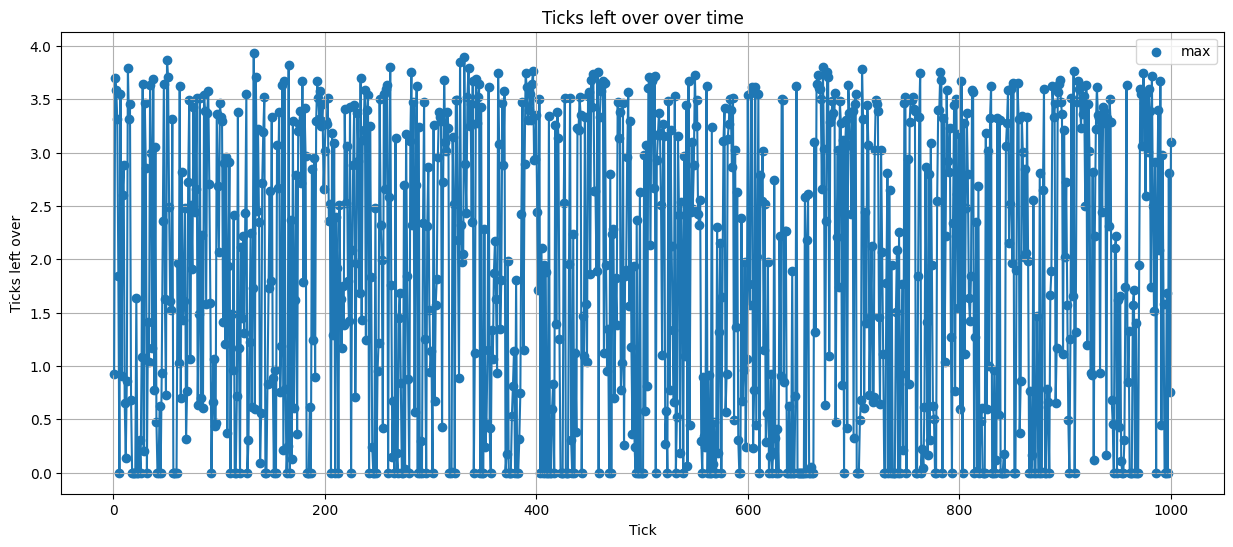

In [7]:
# utilization

# plot range per tick?
out = util_metrics.groupby("tick")["ticksLeftOver"].agg(['min', 'max']).reset_index()

plt.figure(figsize=(15,6))
plt.scatter(out["tick"], out["max"], label="max")
plt.plot(out["tick"], out["max"])

# plt.scatter(out["tick"], out["min"], color='lightblue', label="min")
# plt.plot(out["tick"], out["min"], color='lightblue')

# plt.scatter(out["tick"], out["max"], color='darkblue', label="max")
# plt.plot(out["tick"], out["max"], color='darkblue')

plt.title('Ticks left over over time')
plt.xlabel('Tick')
plt.ylabel('Ticks left over')
plt.grid(True)
plt.legend()
plt.show()



In [114]:
out.sort_values("range", ascending=False).reset_index(drop=True)

,tick,min,max,range
0,381,0.00,3.83,3.83
1,378,1.26,4.89,3.63
2,233,0.00,3.51,3.51
3,377,0.84,4.32,3.48
4,374,0.61,3.95,3.34
...,...,...,...,...
995,595,0.00,0.00,0.00
996,865,0.00,0.00,0.00
997,253,0.00,0.00,0.00
998,262,0.00,0.00,0.00


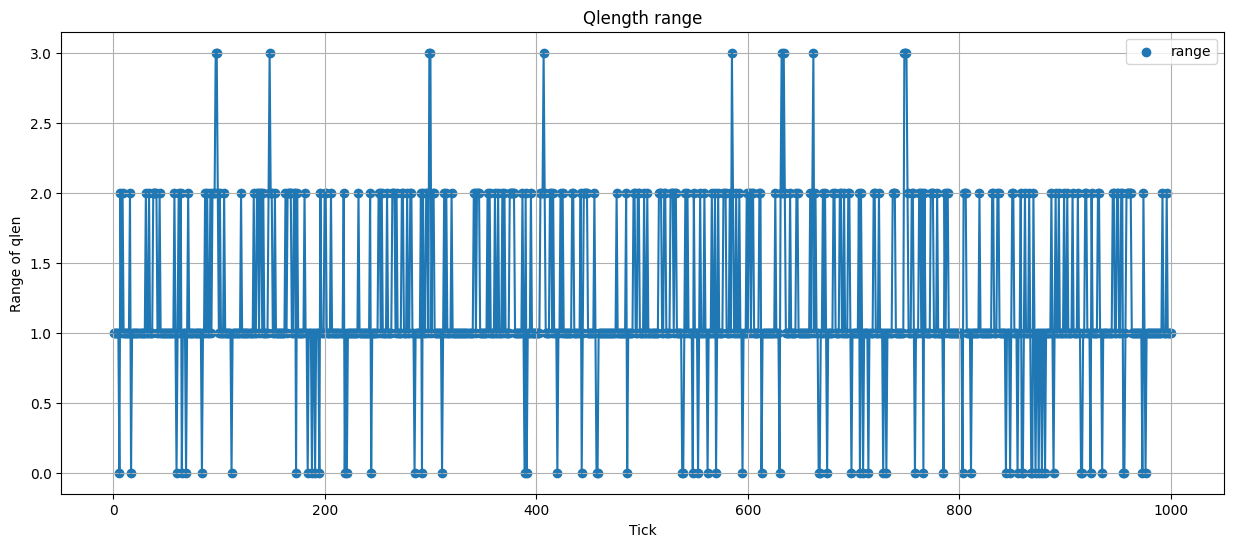

In [161]:
# q length

# plot range per tick?
out = util_metrics.groupby("tick")["qlen"].agg(['min', 'max', 'mean']).reset_index()
out['range'] = out['max'] - out['min']

plt.figure(figsize=(15,6))
plt.scatter(out["tick"], out["range"], label="range")
plt.plot(out["tick"], out["range"])

# plt.scatter(out["tick"], out["min"], color='lightblue', label="min")
# plt.plot(out["tick"], out["min"], color='lightblue')

# plt.scatter(out["tick"], out["max"], color='darkblue', label="max")
# plt.plot(out["tick"], out["max"], color='darkblue')

plt.title('Qlength range')
plt.xlabel('Tick')
plt.ylabel('Range of qlen')
plt.grid(True)
plt.legend()
plt.show()

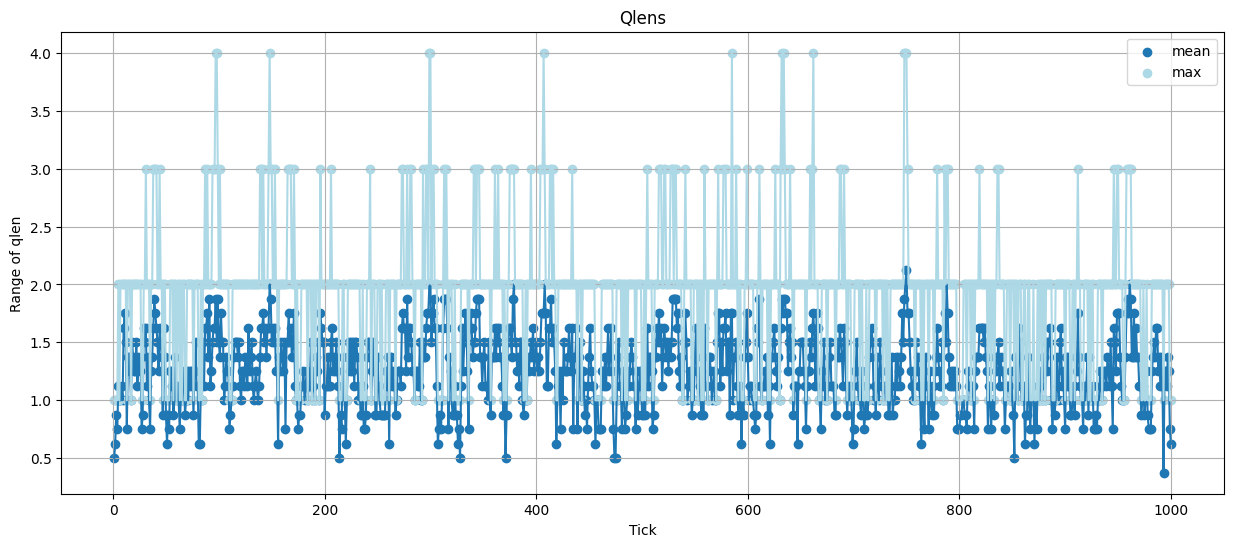

In [166]:
plt.figure(figsize=(15,6))
plt.scatter(out["tick"], out["mean"], label="mean")
plt.plot(out["tick"], out["mean"])

plt.scatter(out["tick"], out["max"], color='lightblue', label="max")
plt.plot(out["tick"], out["max"], color='lightblue')

plt.title('Qlens')
plt.xlabel('Tick')
plt.ylabel('Range of qlen')
plt.grid(True)
plt.legend()
plt.show()

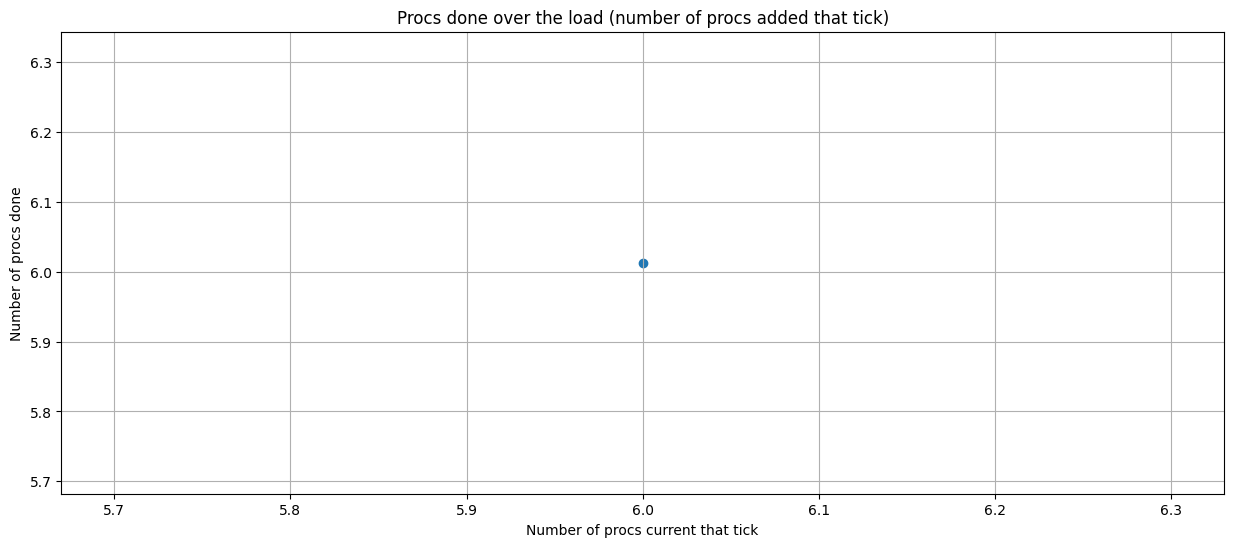

In [115]:
# Procs done over the load (number of procs currently live)
 
num_done = procs_done[["tick"]].groupby("tick").size().reset_index(name='numProcsDone')

merged_done_added = pd.merge(num_done, load_num_procs_per_tick, on='tick', how='left')

avg_done = merged_done_added[["numProcsCurrent", "numProcsDone"]].groupby("numProcsCurrent").mean().reset_index()

plt.figure(figsize=(15,6))
plt.scatter(avg_done["numProcsCurrent"], avg_done["numProcsDone"])
plt.plot(avg_done["numProcsCurrent"], avg_done["numProcsDone"])

plt.title('Procs done over the load (number of procs added that tick)')
plt.xlabel('Number of procs current that tick')
plt.ylabel('Number of procs done')
plt.grid(True)
plt.show()

--------------------------------

# Procs late overview

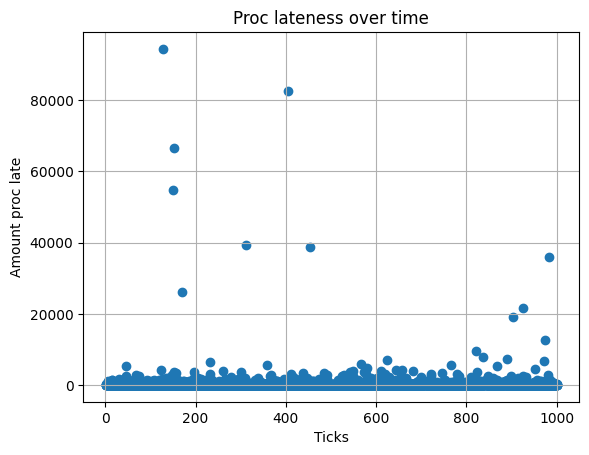

In [125]:
# plot by tick
plt.scatter(procs_late["tick"], procs_late['timePassedAsPct'].values)
plt.xlabel('Ticks')
plt.ylabel('Amount proc late')
plt.title('Proc lateness over time')
plt.grid(True)
plt.show()

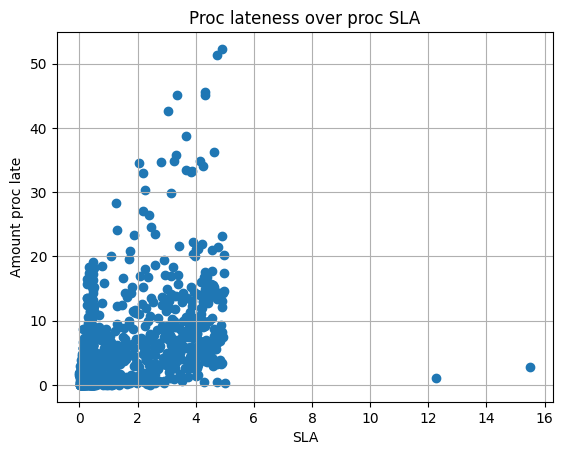

In [97]:
# plot by SLA
plt.scatter(procs_late["sla"], procs_late['amountLate'].values)
plt.xlabel('SLA')
plt.ylabel('Amount proc late')
plt.title('Proc lateness over proc SLA')
plt.grid(True)
plt.show()

# Procs killed overview

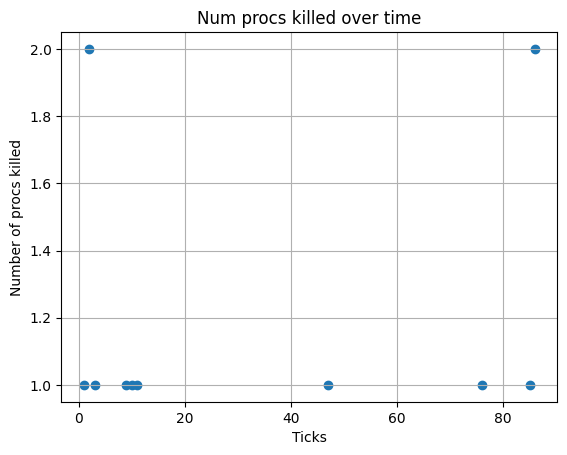

In [98]:
# plot by tick
ticks_procs_killed = procs_killed[["tick"]].groupby("tick").size().reset_index(name='counts')
ticks_procs_killed

plt.scatter(ticks_procs_killed["tick"], ticks_procs_killed['counts'].values)
plt.xlabel('Ticks')
plt.ylabel('Number of procs killed')
plt.title('Num procs killed over time')
plt.grid(True)
plt.show()

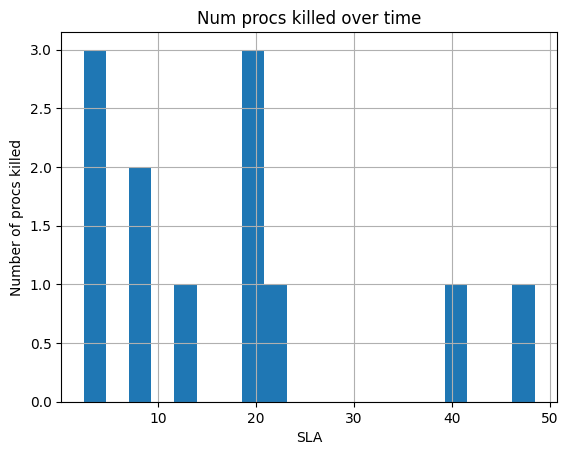

In [102]:
# plot by SLA
plt.hist(procs_killed["sla"], bins=20)
plt.xlabel('SLA')
plt.ylabel('Number of procs killed')
plt.title('Num procs killed over time')
plt.grid(True)
plt.show()

# Utilization Overview

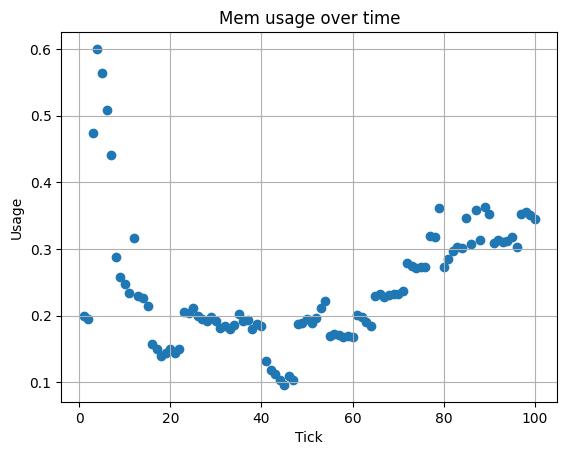

In [121]:
# plot memory usage over time
grouped = active_machines_usage.groupby('tick')["memUsage"].mean().reset_index()
# grouped["tick"]
plt.scatter(grouped["tick"], grouped["memUsage"])
plt.xlabel('Tick')
plt.ylabel('Memory Usage')
plt.title('Mem usage over time')
plt.grid(True)
plt.show()

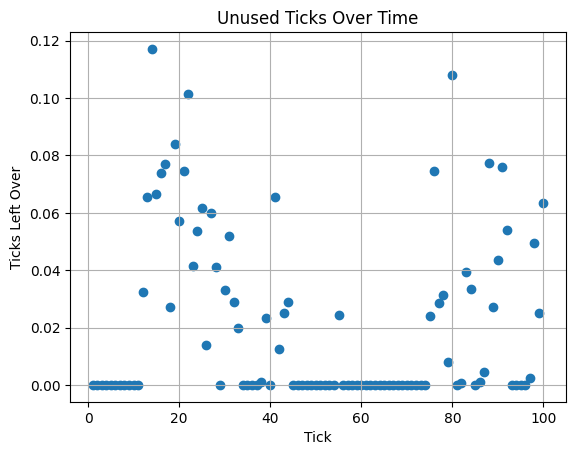

In [123]:
# plot ticks left over, over time
grouped = active_machines_usage.groupby('tick')["unusedTicks"].mean().reset_index()
# grouped["tick"]
plt.scatter(grouped["tick"], grouped["unusedTicks"])
plt.xlabel('Tick')
plt.ylabel('Ticks Left Over')
plt.title('Unused Ticks Over Time')
plt.grid(True)
plt.show()